<font size=4>
Registration number: 210616

Import Necessary Libraries

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from my_functions import abs_att, policy_risk
from my_functions_2 import get_ps_weights, plot_feature_importance

<font size=5>
Read data set

In [2]:
df = pd.read_csv("jobs.csv")
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t,y,e
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0,1.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0,1.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0,1.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0,1.0,1.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0,1.0,0.0


Check how balanced the data is

In [3]:
df.value_counts('t')

t  
0.0    2915
1.0     297
dtype: int64

Confirm the number of samples

In [4]:
df.index

RangeIndex(start=0, stop=3212, step=1)

Check if there is any missing data 
(There isn't)

In [27]:
df.isnull().sum(axis = 0)

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
t      0
y      0
e      0
dtype: int64

Quick analysis with the median and mean of the outcomes

In [28]:
df.groupby('t')['y'].agg(['median','mean'])

,median,mean
t,,
0.0,1.0,0.857633
1.0,1.0,0.774411


Histogram of both treated and untreated outcomes

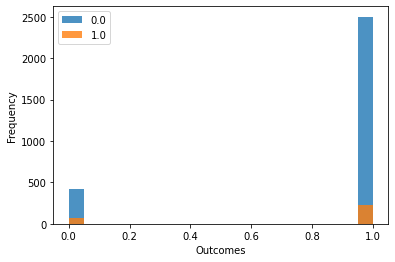

In [30]:
df.groupby('t')['y'].plot(kind='hist', bins=20, alpha=0.8, legend=True)
plt.xlabel('Outcomes')
plt.savefig('JOBS_Outcome.png', dpi=1200)

Divide the background variables, treatment, outcome and experiment data

In [5]:
X=df[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17']]
T=df['t']
Y=df['y']
e=df['e']

Quick visualisation of the data

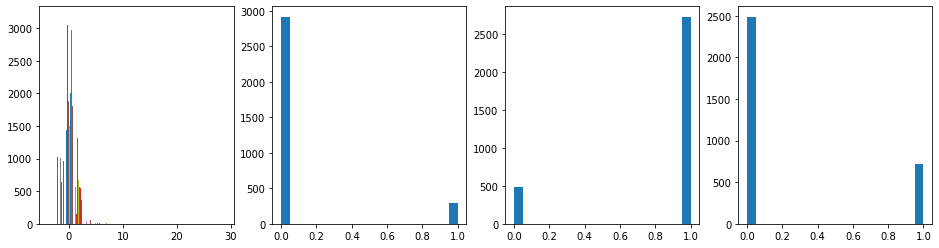

In [6]:
bins=20
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].hist(X, bins=bins)
axs[1].hist(T, bins=bins)
axs[2].hist(Y, bins=bins)
axs[3].hist(e, bins=bins)
plt.show()

<font size=5>
Preprocessing

Split the data and scale it

In [7]:
x_train, x_test, t_train, t_test, y_train, y_test, e_train, e_test = train_test_split(X, T, Y, e, test_size=0.2)

t_train = t_train.to_numpy()
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

Concatenate the x and t training data to prepare it for the Random Forest Regressor

In [8]:
xt_train = np.concatenate([x_train,t_train.reshape(-1,1)], axis=1)


<font size=5>
Fit the data to the model

In [9]:
from sklearn.model_selection import cross_validate
regr = RandomForestRegressor(random_state=0)
cv = cross_validate(regr, xt_train,y_train, cv=10)
sorted(cv.keys())
['fit_time', 'score_time', 'test_score']
cv['test_score'].mean()

0.2401561171977622

Make predictions

In [10]:
regr.fit(xt_train,y_train.flatten())
#Not Treated
xt_zero = np.concatenate([x_test,np.zeros_like(t_test).reshape(-1,1)], axis=1)
y_zero = regr.predict(xt_zero)
#Treated
xt_one = np.concatenate([x_test,np.ones_like(t_test).reshape(-1,1)], axis=1)
y_one = regr.predict(xt_one)

In [11]:
effectEstimate = y_one-y_zero

<font size=5>
Metric Evaluation

In [14]:
att = abs_att(effectEstimate, y_test, t_test, e_test)
Rpol = policy_risk(effectEstimate, y_test, t_test, e_test)


In [16]:
results_ = []
results_.append(['RF', att, Rpol])
cols_ = ['Method', 'ATT test', 'Risk Policy']
eval = pd.DataFrame(results_, columns=cols_)
eval

,Method,ATT test,Risk Policy
0,RF,0.051809,0.293129


<font size=5>
Hyperparameter Optimisation

In [58]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

def optimise(xt_train, y_train, grid=random_grid):
    opt = RandomizedSearchCV(RandomForestRegressor(), param_distributions=grid, n_iter=100, cv=10, verbose=2, n_jobs=-1)
    opt.fit(xt_train, y_train)
    return opt.best_params_ 

def optimise_Weight(xt_train, y_train, weights, grid=random_grid):
    opt = RandomizedSearchCV(RandomForestRegressor(), param_distributions=grid, n_iter=100, cv=10, verbose=2, n_jobs=-1)
    opt.fit(xt_train, y_train, sample_weight=weights)
    return opt.best_params_ 

In [20]:
print(optimise(xt_train,y_train))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


In [22]:
opt_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40 , 50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [800, 1000, 1200]
}

gridSearch = GridSearchCV(estimator = RandomForestRegressor(), param_grid = opt_grid, cv = 10, n_jobs = -1, verbose = 2)
gridSearch.fit(xt_train, y_train)
gridSearch.best_params_

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 1200}

Metric Evaluation

In [23]:
regr_Opt = RandomForestRegressor(bootstrap=True, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=12, n_estimators=1200)
regr_Opt.fit(xt_train, y_train)

regr_Opt.fit(xt_train,y_train.flatten())
#Treated
y_zero_Opt = regr_Opt.predict(xt_zero)
#Not Treated
y_one_Opt = regr_Opt.predict(xt_one)

In [24]:
effectEstimate_Opt = y_one_Opt-y_zero_Opt

In [51]:
att_Opt = abs_att(effectEstimate_Opt, y_test, t_test, e_test)
Rpol_Opt = policy_risk(effectEstimate_Opt, y_test, t_test, e_test)

In [52]:
results_ = []
results_.append(['RF', att, Rpol])
results_.append(['RF_Opt', att_Opt, Rpol_Opt])
cols_ = ['Method', 'ATT test', 'Risk Policy']
eval = pd.DataFrame(results_, columns=cols_)
eval

,Method,ATT test,Risk Policy
0,RF,0.051809,0.293129
1,RF_Opt,0.015886,0.244608


In [45]:
df2 = pd.read_csv("jobs.csv")
df3=df2.drop(['y','e'], axis=1)
df3.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,t
0,-0.614282,1.464727,0.0,0.0,1.0,0.0,2.393250,2.746196,-0.653311,-0.656913,1.627531,2.462337,2.937244,0.0,0.0,2.843909,0.0,0.0
1,-0.802463,0.101835,0.0,0.0,1.0,0.0,0.109885,0.498271,-0.785284,-0.743407,-0.022502,-0.177193,0.082537,0.0,0.0,0.038422,0.0,0.0
2,-0.896553,-0.238888,1.0,0.0,1.0,1.0,-0.085212,-0.148097,-0.847312,-0.781606,-0.361348,-0.286221,-0.303615,0.0,0.0,-0.191304,0.0,0.0
3,-0.896553,-0.238888,0.0,0.0,0.0,1.0,0.405581,0.325594,-0.847312,-0.781606,-0.361348,0.023020,-0.039630,0.0,0.0,0.173108,0.0,0.0
4,0.138440,-1.601779,1.0,0.0,1.0,1.0,-0.722531,-0.212734,-0.019840,-0.156019,-1.422084,-0.514563,-0.331552,0.0,0.0,-0.779227,0.0,0.0


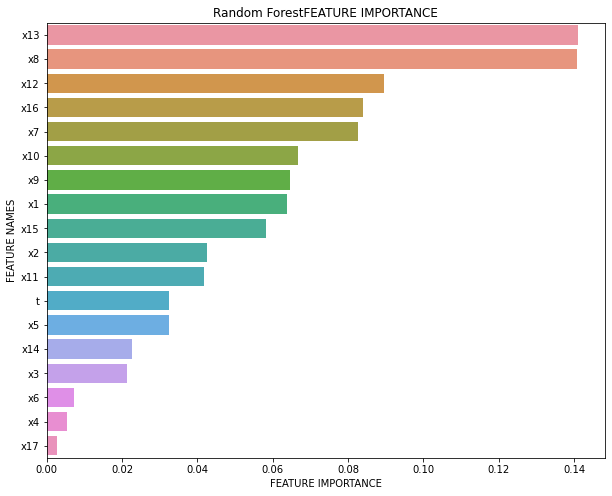

In [46]:

plot_feature_importance(regr_Opt.feature_importances_, df3.columns, 'Random Forest')

<font size=5>
Propensity Score Re-Weighting

In [48]:
# Get the sample weights
clf = RandomForestClassifier()
weights = get_ps_weights(clf, x_train, t_train)

# Train the regressor
regr_ipsw = RandomForestRegressor()

regr_ipsw.fit(np.concatenate([x_train,t_train.reshape(-1,1)], axis=1), y_train.flatten(), sample_weight=weights)

# Make predictions
rf_ipsw_y0_test = regr.predict(np.concatenate([x_test,np.zeros_like(t_test).reshape(-1,1)], axis=1))
rf_ipsw_y1_test = regr.predict(np.concatenate([x_test,np.ones_like(t_test).reshape(-1,1)], axis=1))

# Compute ITEs
rf_ipsw_te_test = np.subtract(rf_ipsw_y1_test, rf_ipsw_y0_test)

In [50]:
att_Ipsw = abs_att(rf_ipsw_te_test, y_test, t_test, e_test)
Rpol_Ipsw = policy_risk(rf_ipsw_te_test, y_test, t_test, e_test)

In [53]:
results_ = []
results_.append(['RF', att, Rpol])
results_.append(['RF_Opt', att_Opt, Rpol_Opt])
results_.append(['RF_Ipsw', att_Ipsw, Rpol_Ipsw])
cols_ = ['Method', 'ATT test', 'Risk Policy']
eval = pd.DataFrame(results_, columns=cols_)
eval

,Method,ATT test,Risk Policy
0,RF,0.051809,0.293129
1,RF_Opt,0.015886,0.244608
2,RF_Ipsw,0.051809,0.293129


Hyperparameter Optimisation

In [60]:
print(optimise_Weight(xt_train, y_train, weights))


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
opt_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40 , 50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [800, 1000, 1200]
}

gridSearch = GridSearchCV(estimator = regr_ipsw, param_grid = opt_grid, cv = 10, n_jobs = -1, verbose = 2)
gridSearch.fit(xt_train, y_train)
gridSearch.best_params_

Feature Importance Plot

In [ ]:
plot_feature_importance(regr_ipsw.feature_importances_, df3.columns, 'Random Forest Weighted')

<font size=5>
Advanced CATE estimators

Example Doubly Robust Learner
by: https://econml.azurewebsites.net/spec/estimation/dr.html 

In [ ]:
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
model_reg = lambda: GridSearchCV(
                estimator=RandomForestRegressor(),
                param_grid={
                        'max_depth': [3, None],
                        'n_estimators': (10, 50, 100)
                    }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
                )
model_clf = lambda: GridSearchCV(
                estimator=RandomForestClassifier(min_samples_leaf=10),
                param_grid={
                        'max_depth': [3, None],
                        'n_estimators': (10, 50, 100)
                    }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
                )
est = DRLearner(model_regression=model_reg(), model_propensity=model_clf(),
                model_final=model_reg(), cv=5)
est.fit(y, T, X=X, W=W)
point = est.effect(X, T0=T0, T1=T1)